In [1]:
import math
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs, make_classification
import seaborn as sns
import pandas as pd
from datasets import blobs, cube

In [2]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances

## Classification in high-dimensional spaces

We have seen that classification in $\mathbb{R}^{2}$ is easy if the classes are well seperated. This matches our intuition. Here, we want to illustrate: Counterintuitive issues with classification in high-dimensional spaces.

As with $\mathbb{R}^{2}$, here we want to generate random points in $\mathbb{R}^{d}$. Here we consider a problem that is simple in 2 dimensions, but challenging in high-dimensional space. 

### Case 1: Easy in low-dimensions but difficult in high-dimensions

In [3]:
X, y = blobs(n_samples=1000, n_features=2, center1=0, center2=4, cluster_std=[1,2])

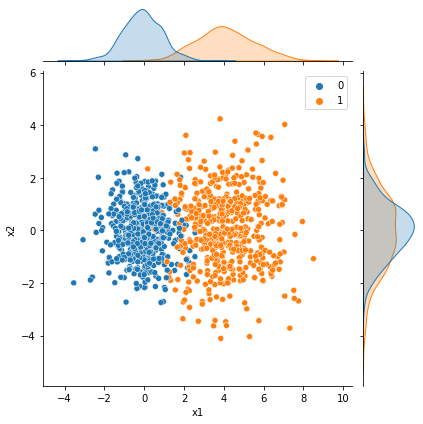

In [4]:
df = pd.DataFrame(data={'x1': X[:,0], 'x2': X[:,1], 'y': y})
sns.jointplot(data=df, x="x1", y="x2", hue=y)

It should be intuitive that this problem is simple in low-dimensional space. However, we will see that this problem can become difficult if we construct additional features, i.e., increase the number of dimensions of the problem. 

In [5]:
ndimensions = np.arange(2, 200, 5)
misclassifcation_rates = []
p = 2 #Euclidean distance
k = 5 #number of nearest neighbors to use

for d in ndimensions:
    X, y = blobs(n_samples=1000, n_features=d, center1=0, center2=4, cluster_std=[1,2])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    
    neigh = KNeighborsClassifier(n_neighbors=k, p=p)
    neigh.fit(X_train, y_train)
    predicted_label_pts = neigh.predict(X_test)
    misclassifcation_rates.append(1-accuracy_score(y_test, predicted_label_pts))

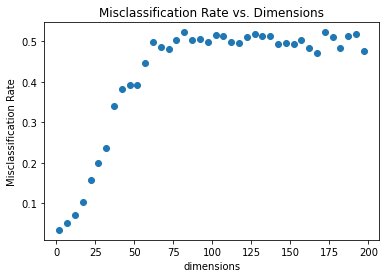

In [6]:
plt.scatter(ndimensions, misclassifcation_rates)
plt.xlabel("dimensions")
plt.ylabel("Misclassification Rate")
plt.title("Misclassification Rate vs. Dimensions")
plt.show()

The plot shows us the missclassifcation rate as a function of the dimensions (number of features). We can see that the missclassification error is very small in low dimensions, but the k-NN classifier fails to discriminate between the two classes in high-dimensions.

When using the k-NN classifier, we make the assumption that points that are close belong to the same class. But as we know, in high dimensional spaces, points that are drawn from a probability distribution, tend to never be close together. We illustrated this in one of the previous sections.

Knowing about this fact, we can come up with a new classifier.

In [7]:
def CommonCenterClassifier(X_train, X_test):
    
    # Learn a Threshold using training data
    threshold = np.mean(np.linalg.norm(X_train, axis=1))
    
    # Classify test data
    preds = [0 if np.linalg.norm(X_test[i,:]) < threshold else 1 for i in range(X_test.shape[0])]  
    
    # Return predictions
    return preds

In [8]:
ndimensions = np.arange(2, 200, 5)
misclassifcation_rates = []

for d in ndimensions:
    X, y = blobs(n_samples=1000, n_features=d, center1=0, center2=4, cluster_std=[1,2])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    predicted_label_pts = CommonCenterClassifier(X_train, X_test)
    misclassifcation_rates.append(1-accuracy_score(y_test, predicted_label_pts))

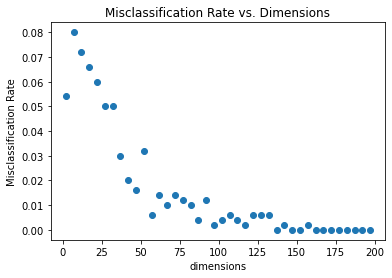

In [9]:
plt.scatter(ndimensions, misclassifcation_rates)
plt.xlabel("dimensions")
plt.ylabel("Misclassification Rate")
plt.title("Misclassification Rate vs. Dimensions")
plt.show()

It can be seen that this classifer improves with increasing dimensions. Why is that? We see a relationship between `d` and `Misclassification Rate` with a fixed, common center for both "**Process A**" and "**Process B**", but the variance in each of the coordinate directions for "**Process B**" is twice as large as that for "**Process A**", namely `var_b = 2 > var_a = 1`. Let's draw some histograms to look into more details of how this classifier works in low vs. high dimensions.

Text(0.5, 1.0, 'd=200')

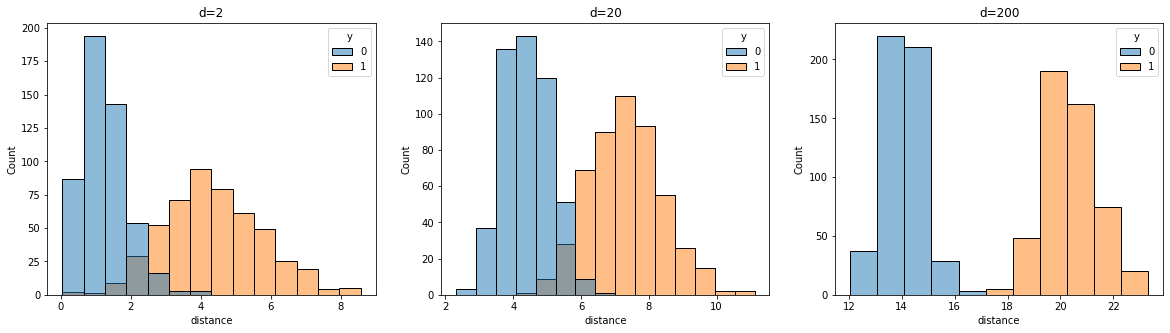

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

X, y = blobs(n_samples=1000, n_features=2, center1=0, center2=4, cluster_std=[1,2])
distance = np.linalg.norm(X, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten(), 'y': y })
sns.histplot(ax=axs[0], data=df, x="distance", hue='y', kde=False)
axs[0].set_title('d=%.0f' %(2))

X, y = blobs(n_samples=1000, n_features=20, center1=0, center2=4, cluster_std=[1,2])
distance = np.linalg.norm(X, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten(), 'y': y })
sns.histplot(ax=axs[1], data=df, x="distance", hue='y', kde=False)
axs[1].set_title('d=%.0f' %(20))

X, y = blobs(n_samples=1000, n_features=200, center1=0, center2=4, cluster_std=[1,2])
distance = np.linalg.norm(X, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten(), 'y': y })
sns.histplot(ax=axs[2], data=df, x="distance", hue='y', kde=False)
axs[2].set_title('d=%.0f' %(200))

The histograms shows that the average distance of class 1 grows faster as compared to class 0. Hence, we can determine a threshold (i.e., a distance) that we can use to discriminate between the two classes.

### Case 2:  Difficult in low-dimensions but easy in high-dimensions

In [11]:
X, y = blobs(n_samples=1000, n_features=2, center1=0, center2=0, cluster_std=[1,2])

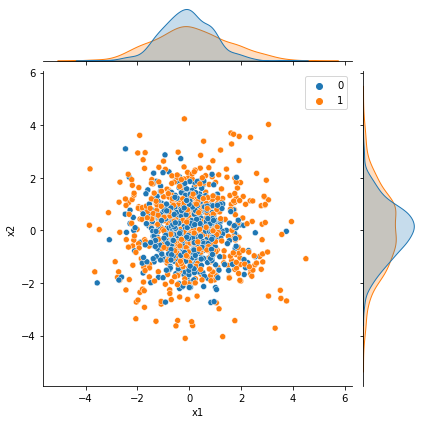

In [12]:
df = pd.DataFrame(data={'x1': X[:,0], 'x2': X[:,1], 'y': y})
sns.jointplot(data=df, x="x1", y="x2", hue=y)

It should be intuitive that this problem is challenging in low-dimensional space. However, we will see that this problem can become easy if we construct additional features, i.e., increase the number of dimensions of the problem. 

In [13]:
ndimensions = np.arange(2, 200, 5)
misclassifcation_rates = []

for d in ndimensions:
    X, y = blobs(n_samples=1000, n_features=d, center1=0, center2=0, cluster_std=[1,2])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    predicted_label_pts = CommonCenterClassifier(X_train, X_test)
    misclassifcation_rates.append(1-accuracy_score(y_test, predicted_label_pts))

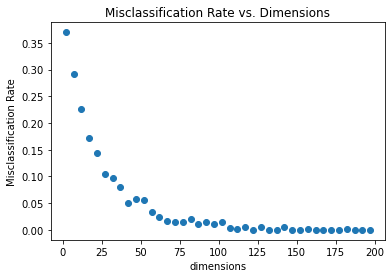

In [14]:
plt.scatter(ndimensions, misclassifcation_rates)
plt.xlabel("dimensions")
plt.ylabel("Misclassification Rate")
plt.title("Misclassification Rate vs. Dimensions")
plt.show()

Again, we can draw some histograms to look into more details of how this classifier works in low vs. high dimensions.

Text(0.5, 1.0, 'd=200')

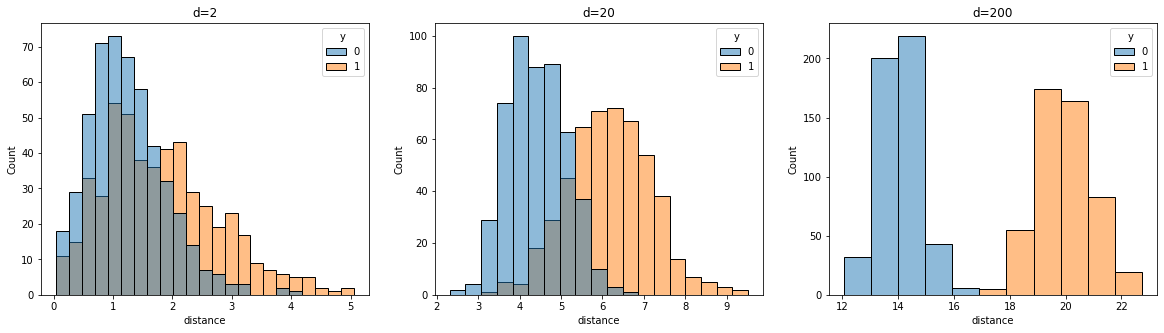

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

X, y = blobs(n_samples=1000, n_features=2, center1=0, center2=0, cluster_std=[1,2])
distance = np.linalg.norm(X, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten(), 'y': y })
sns.histplot(ax=axs[0], data=df, x="distance", hue='y', kde=False)
axs[0].set_title('d=%.0f' %(2))

X, y = blobs(n_samples=1000, n_features=20, center1=0, center2=0, cluster_std=[1,2])
distance = np.linalg.norm(X, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten(), 'y': y })
sns.histplot(ax=axs[1], data=df, x="distance", hue='y', kde=False)
axs[1].set_title('d=%.0f' %(20))

X, y = blobs(n_samples=1000, n_features=200, center1=0, center2=0, cluster_std=[1,2])
distance = np.linalg.norm(X, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten(), 'y': y })
sns.histplot(ax=axs[2], data=df, x="distance", hue='y', kde=False)
axs[2].set_title('d=%.0f' %(200))

## Projected k-NN classifier

There are many other methods that can be used to improve the classification performance, of course. For example, you will learn more about principal component analysis in a few weeks from now. Without explaining the details here, we use principal component analysis to extract low-dimensional features that we then use to train a k-NN classifier. 

In [16]:
ndimensions = np.arange(2, 200, 5)
misclassifcation_rates = []

for d in ndimensions:
    X, y = blobs(n_samples=1000, n_features=2, center1=0, center2=4, cluster_std=[1,2])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    mean = np.mean(X_train,axis=0)
    U,s,Vt = np.linalg.svd(X_train-mean, False)
    X_train = (X_train-mean).dot(Vt[0:2,:].T)
    X_test = (X_test-mean).dot(Vt[0:2,:].T)
    
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X_train, y_train)
    predicted_label_pts = neigh.predict(X_test)
    misclassifcation_rates.append(1-accuracy_score(y_test, predicted_label_pts))

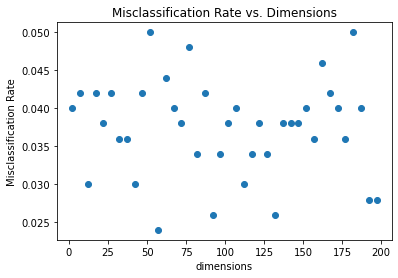

In [17]:
plt.scatter(ndimensions, misclassifcation_rates)
plt.xlabel("dimensions")
plt.ylabel("Misclassification Rate")
plt.title("Misclassification Rate vs. Dimensions")
plt.show()

You can see that the classification performance is independent of the dimensions for case 1. To gain some intuition, we can simply visualize the projected data in two-dimensional space.

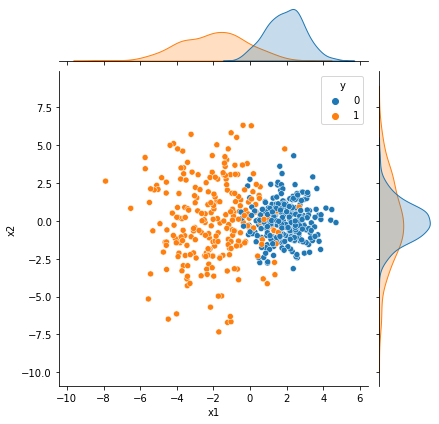

In [18]:
X, y = blobs(n_samples=1000, n_features=200, center1=0, center2=4, cluster_std=[1,2])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
mean = np.mean(X_train,axis=0)
U,s,Vt = np.linalg.svd(X_train-mean, False)
X_train = (X_train-mean).dot(Vt[0:2,:].T)
X_test = (X_test-mean).dot(Vt[0:2,:].T)

df = pd.DataFrame(data={'x1': X_train[:,0], 'x2': X_train[:,1], 'y': y_train})
sns.jointplot(data=df, x="x1", y="x2", hue="y")